<a href="https://colab.research.google.com/github/pkpk1717/Skin-cancer-lesion-detection/blob/master/TestProjectOnLesions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The HAM10000 Skin Lesion dataset

[LINK TO ORIGINAL DATASET](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)


[ORIGINAL RESEARCH PAPER ON DATASET](https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf)

- Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. 


- We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. 


- Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: 
 - Actinic keratoses and intraepithelial carcinoma / Bowen's disease (**akiec**), 
 - basal cell carcinoma (**bcc**), 
 - benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, **bkl**),
 - dermatofibroma (**df**),
 - melanoma (**mel**),
 - melanocytic nevi (**nv**)
 - and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, **vasc**).



- More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

# Notebook overview

The dataset is analyzed over 2 Neural architecture: 
 - Simple Squential architecture
 - Custom ResNet (Functional API)
 
**Simple Sequential Architecture :**  The simple architecture contains convolution and max pool layer stack. This architecture is just to know how dataset behaves on simpler architecture. It follows the below architecture: 
 - **INPUT>>CN>>BN>>CN>>BN>>CN>>BN>>MP   >>   CN>>BN>>CN>>BN>>CN>>BN>>MP >>      CN>>BN>>CN>>BN>>CN>>BN>>     CN>>BN>>CN>>OUTPUT**
 
 
**Custom ResNet :** We create a convolution batch normalized layer followed by 4 residual blocks. Then the global averaged pool output is feed to the softmax to produce the output. This architecture is customly designed inspired from ResNet18.


Along with ResNet, we also hve used triangular CLR policy. Max Learning rate is set to 0.1 and min to 0.001. The step size is set to 2 * *StepsPerEpoch*
 

### Importing required libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.colab import files
import os
import zipfile

from glob import glob
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras import regularizers, initializers
from keras.layers.advanced_activations import LeakyReLU, ReLU, Softmax
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras.utils import plot_model
from keras.models import load_model

Using TensorFlow backend.


### Loading the Kaggle API since we are downloading dataset from kaggle

In [0]:
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
import kaggle
print("Imported kaggle API successfully !")

Saving kaggle.json to kaggle.json
Imported kaggle API successfully !


In [0]:
print("Downloading dataset : ")
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000/downloads/skin-cancer-mnist-ham10000.zip
print("Downloaded Successfully!")

 99% 2.60G/2.62G [00:25<00:00, 122MB/s]
100% 2.62G/2.62G [00:25<00:00, 112MB/s]
Downloaded Successfully!


### Extracting dataset and removing unwanted files

In [0]:
zip_ref = zipfile.ZipFile('skin-cancer-mnist-ham10000.zip', 'r')
zip_ref.extractall()
zip_ref.close()
os.unlink('skin-cancer-mnist-ham10000.zip')

In [0]:
print('Extracting Images into single directory')
os.mkdir('images')
zip_ref = zipfile.ZipFile('HAM10000_images_part_1.zip', 'r')
zip_ref.extractall('images/')
zip_ref.close()
os.unlink('HAM10000_images_part_1.zip')
zip_ref = zipfile.ZipFile('HAM10000_images_part_2.zip', 'r')
zip_ref.extractall('images/')
zip_ref.close()
os.unlink('HAM10000_images_part_2.zip')

Extracting Images into single directory


In [0]:
li = ['hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_28_28_L.csv']
for i in li:
    os.unlink(i)

In [0]:
os.listdir()

['.config', 'HAM10000_metadata.csv', 'kaggle.json', 'images', 'sample_data']

# Exploratory data analysis

Loading dataset csv in pandas DataFrame

In [0]:
main_df = pd.read_csv('HAM10000_metadata.csv')
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


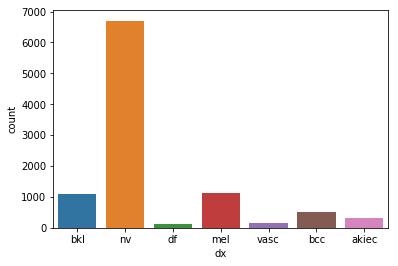

In [0]:
sns.countplot(main_df['dx'])

In [0]:
main_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

We see that in the dataset, we have 7 different classes and people are most affected by NV skin cancer.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

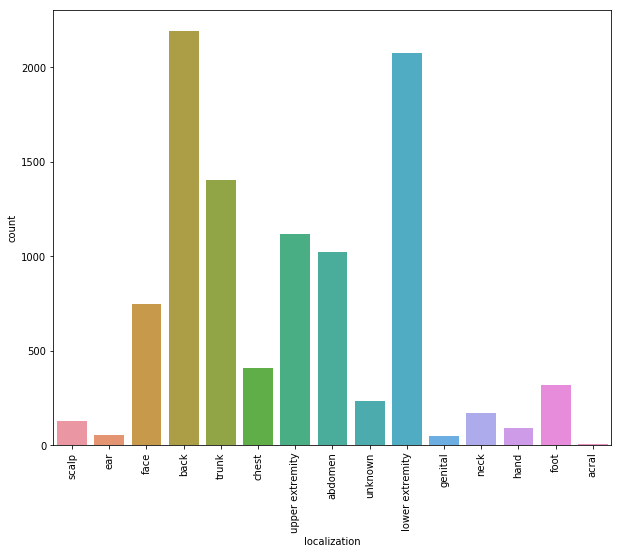

In [0]:
plt.figure(figsize=(10,8))
sns.countplot(main_df['localization'])
plt.xticks(rotation=90)

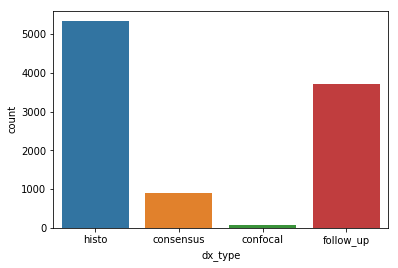

In [0]:
sns.countplot(main_df['dx_type'])

In [0]:
main_df['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [0]:
main_df.isna().sum().sort_values(ascending=False)

age             57
localization     0
sex              0
dx_type          0
dx               0
image_id         0
lesion_id        0
dtype: int64

We have some missing values in the "age" feature. So, lets fill it either use mean or median of the "age" feature

In [0]:
print(main_df['age'].mean())
print(main_df['age'].median())
main_df['age'].fillna(main_df['age'].mean(),inplace=True)

51.863828077927295
50.0


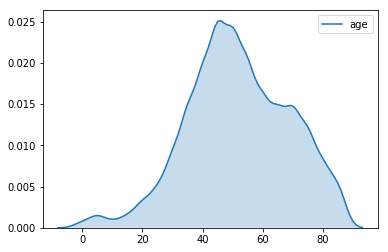

In [0]:
sns.kdeplot(main_df['age'],shade=True)

Most of the affected people are their ages between 35 to 70

In [0]:
main_df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

Lets create a dictionary to feed in label values in our dataframe

In [0]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

main_df['cell_type'] = main_df['dx'].map(lesion_type_dict)

In [0]:
main_df['cell_type_idx'] = pd.Categorical(main_df['cell_type']).codes

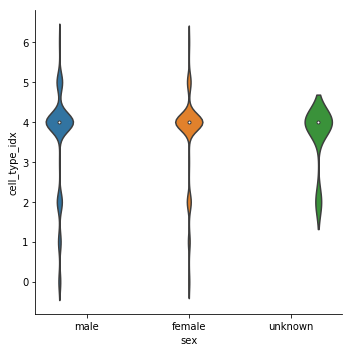

In [0]:
sns.catplot(x="sex", y="cell_type_idx",
                    hue="sex",
                    data=main_df,
                    kind="violin")

We can infer using the above plot that, Male sex are most efftect by Cell type 4 and 5, whereas, Female sex are effected by 4 mainly. Other sex also have been effected by 4 and 2. 

Major cell type in sex is dominated by 4.

In [0]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('', '*', '*.jpg'))}

In [0]:
main_df['path'] = main_df['image_id'].map(image_path.get)
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,images/ISIC_0031633.jpg


let's look at sample Image

In [0]:
 image_example = np.asarray(pil_image.open(main_df['path'][0]))

In [0]:
image_example.shape

(450, 600, 3)

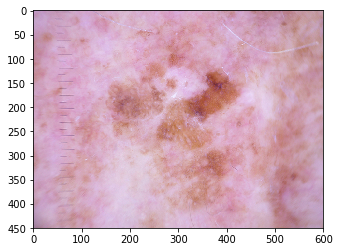

In [0]:
plt.imshow(image_example)

The image size is very large and difficult to train and will take lot of time. So let's resize it to 1:5 ratio.

The ratio is not calculated as per some base but rather, an intuition based value.

In [0]:
main_df['image'] = main_df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((120,90))))

In [0]:
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0027419.jpg,"[[[190, 153, 196], [195, 156, 200], [190, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0025030.jpg,"[[[25, 12, 21], [25, 13, 23], [23, 12, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0026769.jpg,"[[[187, 125, 136], [191, 135, 148], [198, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,images/ISIC_0025661.jpg,"[[[23, 12, 18], [24, 11, 18], [29, 16, 26], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,images/ISIC_0031633.jpg,"[[[128, 89, 110], [143, 99, 122], [153, 108, 1..."


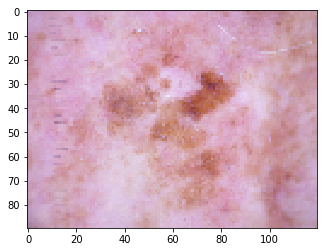

In [0]:
plt.imshow(main_df['image'][0])

We can see that only a few of the features are dampened, however, almost all the features are sitll preserved. 

In [0]:
main_df['image'][0].shape

(90, 120, 3)

### Sample of 5 images in each class

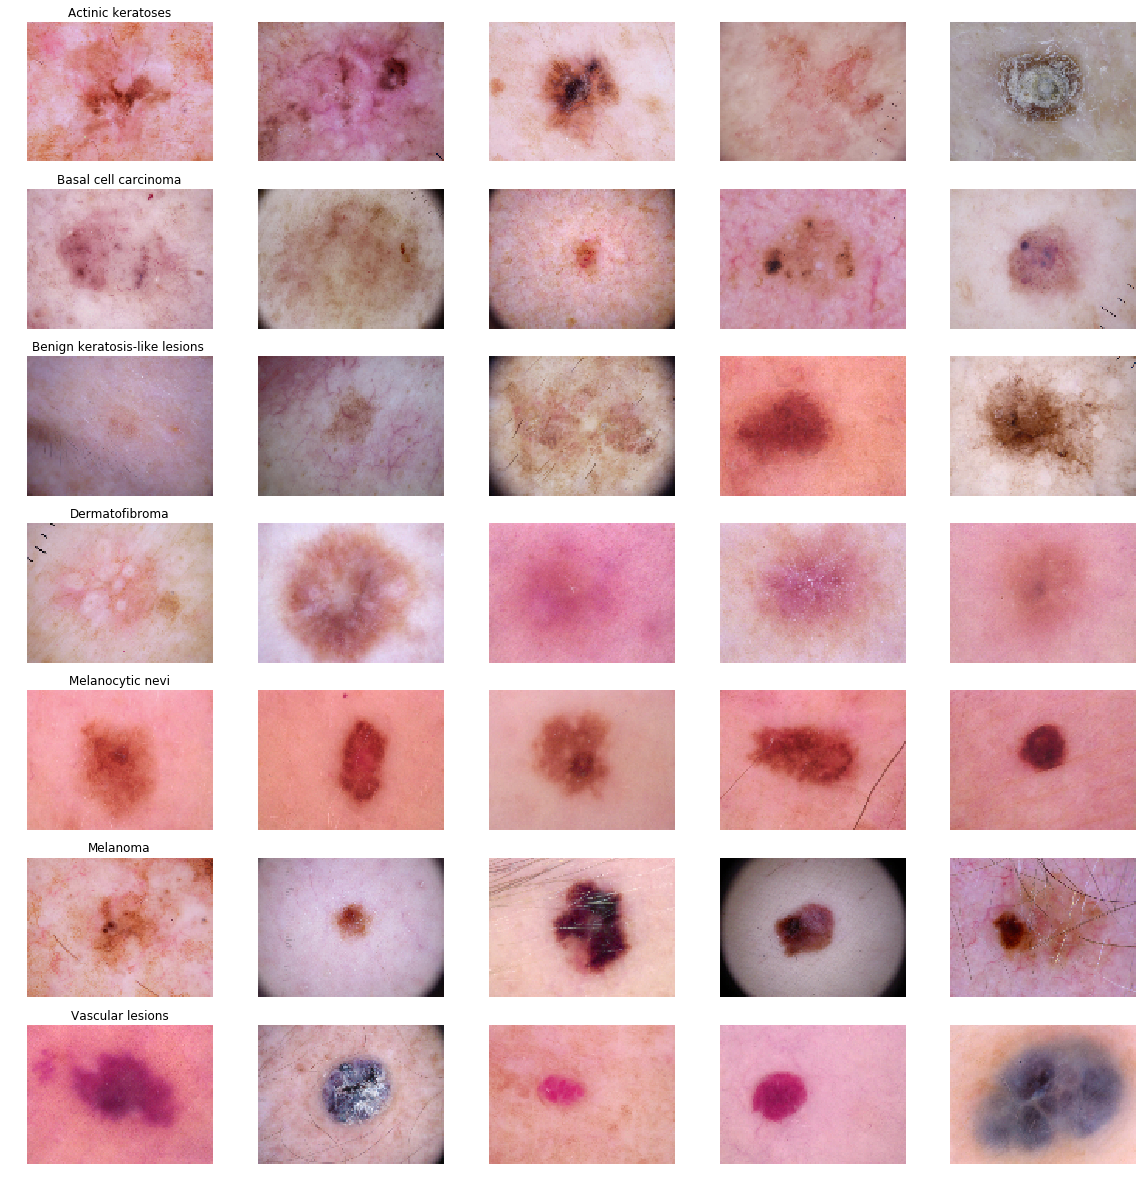

In [0]:
fig,axes = plt.subplots(7,5,figsize=(20,21))
for nth_axis,(cell_type_name,cell_type_row) in zip(axes,main_df.sort_values(['cell_type']).groupby('cell_type')):
    nth_axis[0].set_title(cell_type_name)
    for column_axis,(_,column_row) in zip(nth_axis,cell_type_row.sample(5).iterrows()):
        column_axis.imshow(column_row['image'])  
        column_axis.axis('off')

# Data Preprocessing and Data Modelling

Let's split the dataset into Trainig and Validation set.

In [0]:
features = main_df.drop(['cell_type_idx'],axis=1)

target = main_df['cell_type_idx']

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)

Creating Image Training and Test set

In [0]:
x_train = np.asarray(X_TRAIN['image'].tolist())
x_test = np.asarray(X_TEST['image'].tolist())

In [0]:
print(x_train.shape)
print(x_test.shape)

(9914, 90, 120, 3)
(101, 90, 120, 3)


In [0]:
train_mean = x_train.mean()
train_std = x_train.std()
test_mean = x_test.mean()
test_std = x_test.std()

In [0]:
print(train_mean)
print(train_std)
print(test_mean)
print(test_std)

159.80161184333414
46.71823530786032
161.30922717271727
46.63439565144805


### Using Image Standardization

We calculate mean and Standard deviation of the image array's and then Standardize the image pixel values using the following formula:

{X-MEAN}/{STD}


In [0]:
x_train = (x_train-train_mean) / train_std
x_test = (x_test-test_mean) / test_std

In [0]:
print(Y_TRAIN.shape)
print(Y_TEST.shape)

(9914,)
(101,)


Converting Nx1 to Nx7 since we have 7 classes

In [0]:
y_train = to_categorical(Y_TRAIN,num_classes=7)
y_test = to_categorical(Y_TEST,num_classes=7)

In [0]:
print(y_train.shape)
print(y_test.shape)

(9914, 7)
(101, 7)


In [0]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

Reshaping so that we can feed this into our neural network

In [0]:
X_train  = X_train.reshape(X_train.shape[0],90,120,3)
x_test  = x_test.reshape(x_test.shape[0],90,120,3)
X_val  = X_val.reshape(X_val.shape[0],90,120,3)

In [0]:
print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

(8426, 90, 120, 3)
(101, 90, 120, 3)
(1488, 90, 120, 3)


# Models 

## 1. Simple Sequential Network


No Dense since I donot prefer dense because we loose all the spatial information and more over Dense converts a 2D output to 1D. So I always try to choose to design a network without Dense.
Also it has major dropback in the total number of parameters. Total number of parameters rise exponentially.

[Impact of full connected layers : Research Paper](https://arxiv.org/pdf/1902.02771.pdf)

In [0]:
input_shape = (90, 120, 3)
num_classes = 7

model = Sequential()

model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',name="conv1", input_shape=input_shape)) #88,118
model.add(BatchNormalization(name="Norm1"))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv2")) #86,116
model.add(BatchNormalization(name="Norm2"))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv3")) #84,114
model.add(BatchNormalization(name="Norm3"))
model.add(MaxPooling2D(pool_size = (2, 2))) # 42,57
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',name="conv4")) #40,55
model.add(BatchNormalization(name="Norm4"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv5")) #38,53
model.add(BatchNormalization(name="Norm5"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv6")) #36,51
model.add(BatchNormalization(name="Norm6"))
model.add(MaxPooling2D(pool_size=(2, 2))) #18,25
model.add(Dropout(0.20))

model.add(Conv2D(128, (3, 3), activation='relu',name="conv7")) #16,23
model.add(BatchNormalization(name="Norm7"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv8")) #14,21
model.add(BatchNormalization(name="Norm8"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv9")) #12,19
model.add(BatchNormalization(name="Norm9"))
model.add(MaxPooling2D(pool_size=(2, 2))) #6,9
model.add(Dropout(0.20))

model.add(Conv2D(7,(1,1),name="conv10",activation="relu")) #6,9
model.add(BatchNormalization(name="Norm10"))
model.add(Conv2D(7,kernel_size=(6,9),name="conv11"))
model.add(Flatten())
model.add(Activation('softmax'))

W0615 16:43:32.839942 140657434515328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 16:43:32.917333 140657434515328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 16:43:32.934506 140657434515328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0615 16:43:32.987060 140657434515328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0615 16:43:32.989519 1406574345

In [0]:
# Compile the model
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

W0615 16:43:41.187421 140657434515328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)

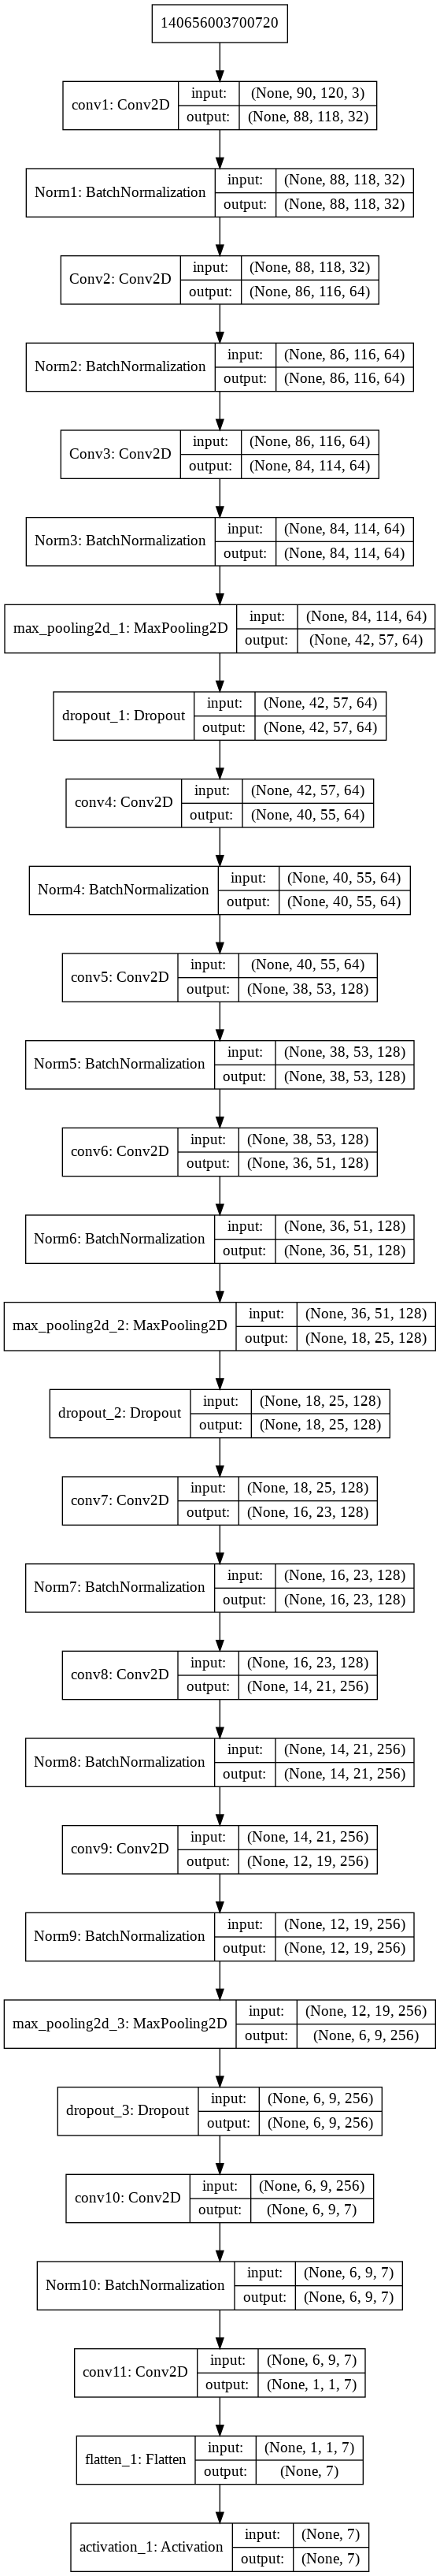

In [0]:
plot_model(model, to_file='simple_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='simple_model_plot.png')

In [0]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)


# Fit the model
epochs = 30
batch_size = 16
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

W0615 16:44:03.547296 140657434515328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
526/526 [==============================] - 37s 71ms/step - loss: 0.9469 - acc: 0.6656 - val_loss: 0.9884 - val_acc: 0.6976
Epoch 2/30
526/526 [==============================] - 32s 60ms/step - loss: 0.8468 - acc: 0.6948 - val_loss: 1.1554 - val_acc: 0.6465
Epoch 3/30
526/526 [==============================] - 32s 60ms/step - loss: 0.8092 - acc: 0.7009 - val_loss: 0.9602 - val_acc: 0.6626
Epoch 4/30
526/526 [==============================] - 32s 60ms/step - loss: 0.7845 - acc: 0.7198 - val_loss: 0.8509 - val_acc: 0.6996
Epoch 5/30
526/526 [==============================] - 31s 60ms/step - loss: 0.7594 - acc: 0.7211 - val_loss: 0.9213 - val_acc: 0.6949
Epoch 6/30
526/526 [==============================] - 31s 60ms/step - loss: 0.7460 - acc: 0.7258 - val_loss: 0.8115 - val_acc: 0.7184
Epoch 7/30
526/526 [==============================] - 31s 60ms/step - loss: 0.7351 - acc: 0.7300 - val_loss: 0.7750 - val_acc: 0.7204
Epoch 8/30
526/526 [==============================] - 31s 60ms

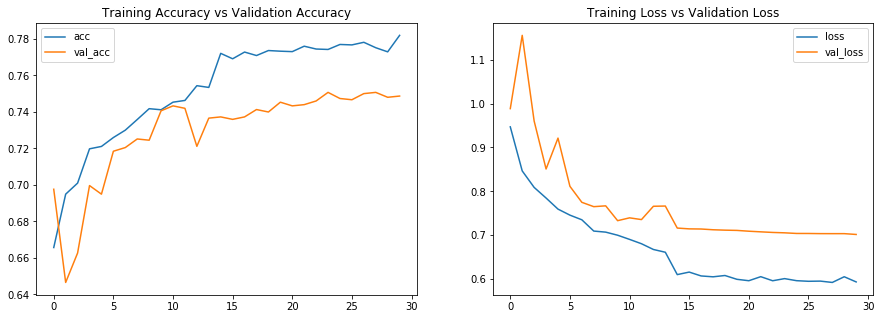

In [0]:
def plot_(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

In [0]:
print("MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is : ", round(max(model.history.history['val_acc'])*100,4))

MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is :  75.0672


### Prediction on new Image

Original Shape of image is :  (1009, 1244, 3)


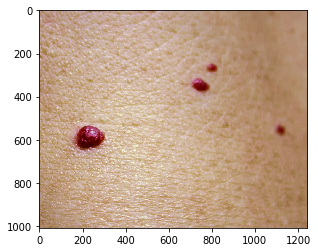

In [0]:
## Let's randomly download a image from internet to test the model.
import urllib

url="https://lazaderm.com/media/library/fluid-ext-editor-widget/124/image/LZ_VascularLesions%20(2)-crop-1244x1009-40932.jpg"

urllib.request.urlretrieve(url,'test.jpg')
test_image = np.asarray(pil_image.open('test.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [0]:
resized_image = np.asarray(pil_image.open('test.jpg').resize((120,90)))
image_array = np.asarray(resized_image.tolist())
test_image = image_array.reshape(1,90,120,3)

In [0]:
prediction_class = model.predict_classes(test_image)
print(prediction_class)
lesion_classes_dict[prediction_class[0]]

[5]


'vasc'

The model correctly predicts the image!

## 2. Custom ResNet

In [0]:
batch_size = 64
num_classes = 7
epochs = 20

'''
dropout:None
L2:0.001
'''
#begin layers
def conv_bn_relu(input, block_no):
  ch_in = 16*(2**block_no)
  c1 = Conv2D(ch_in, (3,3),
#               kernel_regularizer=regularizers.l2(0.001),
              kernel_initializer='glorot_uniform',
              padding='same', 
              name='begin_block{}_conv1'.format(block_no),
              use_bias=False)(input)
  c1 = BatchNormalization(name='begin_block{}_norm1'.format(block_no))(c1)
  c1 = ReLU()(c1)
  
  return c1

# Custom ResBlock
def add_resblock(input, dropout_rate = None, layers=2, block_no=1, first_block=False, final_block=False):

#   ch_in = 32 if input.shape[3]==3 else input.shape[3]*2
  ch_in = input.shape[3]*2
#   ch_in = 32 if first_block else input.shape[3]*2
  temp = input
  
  for l in range(layers):
    c1 = Conv2D(int(ch_in*(2**l)),
                (3,3),
                kernel_regularizer=regularizers.l2(0.001),
#                 kernel_initializer='glorot_uniform',
                use_bias=False,
                padding='same', 
                name = 'res_block{}_conv{}'.format(block_no, l+1))(temp)
    if dropout_rate!=None:
      c1 = Dropout(dropout_rate)(c1)
      
    c1 = BatchNormalization(name = 'res_block{}_BN{}'.format(block_no, l+1))(c1)
        
    c1 = ReLU(name = 'res_block{}_relu{}'.format(block_no, l+1))(c1)
    
    temp = c1

    
  concat = Concatenate(axis=-1)([input,temp])


  if not final_block:

    tr_layer = Conv2D(int(ch_in), (1,1),
                      kernel_regularizer=regularizers.l2(0.001),
                      use_bias=False,
                      padding='same', 
                      name = 'res_block{}_transition'.format(block_no))(concat)
    tr_layer = BatchNormalization(name = 'res_block_transition1x1{}_BN'.format(block_no))(tr_layer)
    tr_layer = ReLU(name = 'res_block_transition1x1{}_relu'.format(block_no))(tr_layer)
    
    
    return MaxPooling2D(pool_size=(2, 2))(tr_layer)
  else:
    return concat




# input = Input(shape=(img_height, img_width, channel,))
# input = Input(shape=train_generator.image_shape)
input = Input(shape=(None, None, 3,))

First_Conv2D = conv_bn_relu(input, block_no=1)
# second_Conv2D = conv_bn_relu(First_Conv2D, block_no=2)
# first_maxpool = MaxPooling2D(pool_size=(2, 2), name = 'startmaxpool')(First_Conv2D)

block1 = add_resblock(First_Conv2D, layers=2, block_no=1, first_block=True)

block2 = add_resblock(block1, layers=2, block_no=2)

block3 = add_resblock(block2, layers=2, block_no=3)

block4 = add_resblock(block3, layers=2, block_no=4, final_block=True)

reduce_ch = Conv2D(num_classes, (1,1), name='ch_size_no_classes', use_bias=False)(block4)
avg_pool = GlobalAveragePooling2D()(reduce_ch)
output = Softmax()(avg_pool)

model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
begin_block1_conv1 (Conv2D)     (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
begin_block1_norm1 (BatchNormal (None, None, None, 3 128         begin_block1_conv1[0][0]         
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, None, None, 3 0           begin_block1_norm1[0][0]         
__________________________________________________________________________________________________
res_block1

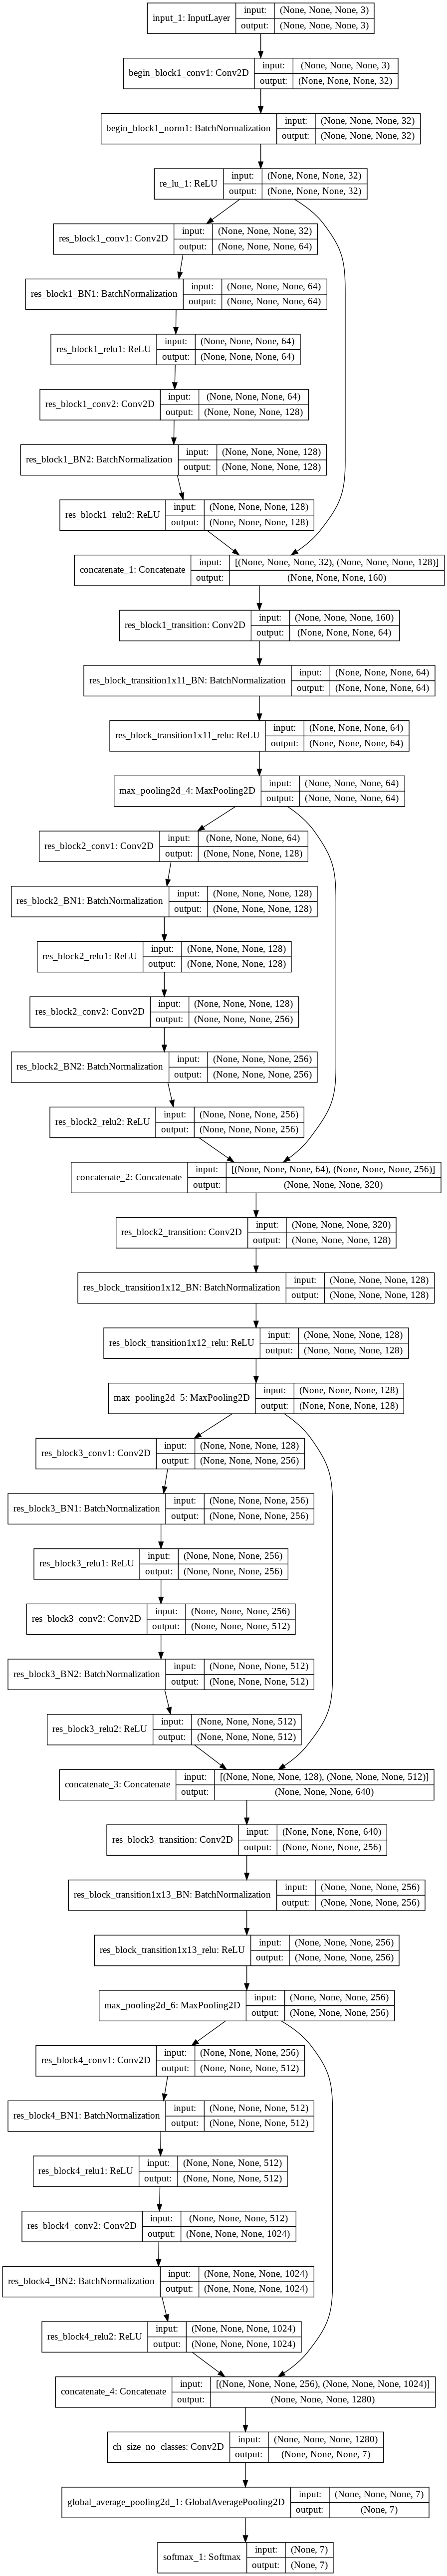

In [0]:
plot_model(model, to_file='resnet_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='resnet_model_plot.png')

### CLR

In [0]:
#Triangle cyclic learning rate policy

class CyclicLR(Callback):
    

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
##1-16 epochs
clr = CyclicLR(base_lr=0.001, max_lr=0.1,
                        step_size=212.)

#SDG 
sgd = SGD(lr=0.1, momentum = 0.9,nesterov=True)
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer=sgd,
              metrics=['accuracy'])

batch_size = 64

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)

datagen.fit(X_train)

#fit
model.fit_generator(
        datagen.flow(X_train,Y_train,batch_size=batch_size),
        steps_per_epoch = X_train.shape[0] // batch_size,
        epochs=16,
        validation_data=(X_val,Y_val),
        verbose=1, callbacks=[clr],
        )

Epoch 1/16
131/131 [==============================] - 68s 519ms/step - loss: 3.4405 - acc: 0.6545 - val_loss: 11.2238 - val_acc: 0.3038
Epoch 2/16
131/131 [==============================] - 63s 481ms/step - loss: 2.7786 - acc: 0.6795 - val_loss: 3.4507 - val_acc: 0.5914
Epoch 3/16
131/131 [==============================] - 59s 448ms/step - loss: 2.2510 - acc: 0.6923 - val_loss: 2.5336 - val_acc: 0.6808
Epoch 4/16
131/131 [==============================] - 59s 447ms/step - loss: 2.0281 - acc: 0.7102 - val_loss: 4.3559 - val_acc: 0.6915
Epoch 5/16
131/131 [==============================] - 59s 447ms/step - loss: 1.8889 - acc: 0.6924 - val_loss: 1.8185 - val_acc: 0.6015
Epoch 6/16
131/131 [==============================] - 59s 447ms/step - loss: 1.5672 - acc: 0.7005 - val_loss: 1.5572 - val_acc: 0.6815
Epoch 7/16
131/131 [==============================] - 59s 447ms/step - loss: 1.3836 - acc: 0.7237 - val_loss: 1.4810 - val_acc: 0.6821
Epoch 8/16
131/131 [==============================] - 

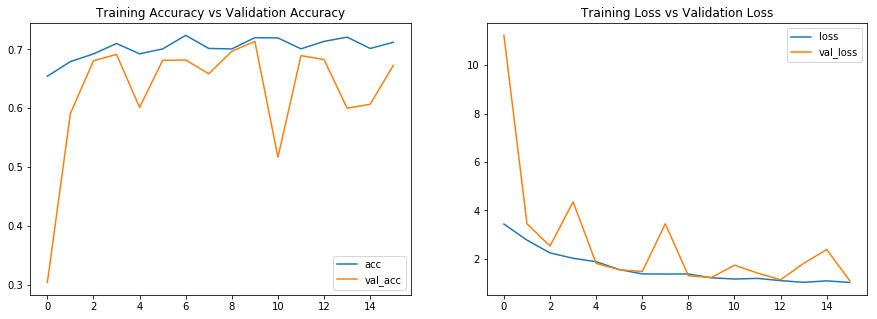

In [0]:
def plot_(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

In [0]:
print("MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is : ", round(max(model.history.history['val_acc']),4)*100)

MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is :  71.37


# Inference on dataset


We see that the Images in the dataset are not hard when comapred to very hard datasets such as Tiny ImageNet. Hence simpler models work better than deep or Wider networks such as resNet.

We can further conclude that the models could be futher hypertuned to produce better results. 

### Predictions on new image


Original Shape of image is :  (1080, 1080, 3)


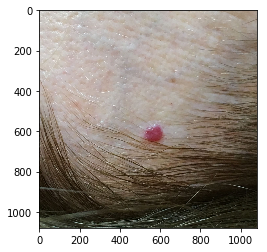

In [0]:
url="https://www.skincorrectives.com/wp-content/uploads/2018/06/vas1.jpg"

urllib.request.urlretrieve(url,'test.jpg')
test_image = np.asarray(pil_image.open('test.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [0]:
resized_image = np.asarray(pil_image.open('test.jpg').resize((120,90)))
image_array = np.asarray(resized_image.tolist())
test_image = image_array.reshape(1,90,120,3)

In [0]:
prediction_class = model.predict(test_image)
prediction_class = np.argmax(prediction_class,axis=1)

In [0]:
prediction_class

array([5])

In [0]:
lesion_classes_dict[prediction_class[0]]

'vasc'

# Prediction of Test set

In [0]:
prediction_on_test = model.predict(x_test)

In [0]:
prediction_on_test

array([[1.89461000e-02, 9.29736067e-03, 2.82440066e-01, 1.35292113e-03,
        1.24470435e-01, 5.61854780e-01, 1.63835892e-03],
       [1.58704445e-01, 2.69122064e-01, 2.53579050e-01, 4.58732732e-02,
        1.56436563e-01, 8.52302536e-02, 3.10544223e-02],
       [5.18142134e-02, 8.53004828e-02, 5.37954032e-01, 1.81782991e-02,
        1.09997906e-01, 1.84780210e-01, 1.19748218e-02],
       [7.41629973e-02, 8.46575126e-02, 3.34958702e-01, 8.39059725e-02,
        3.32829386e-01, 4.12404723e-02, 4.82449830e-02],
       [3.38500854e-06, 1.33856446e-07, 1.42194622e-05, 1.06828509e-07,
        8.52177739e-02, 9.14763868e-01, 3.86560004e-07],
       [2.07504518e-02, 4.44793850e-02, 2.72517174e-01, 1.58108026e-02,
        4.72327769e-01, 1.59432679e-01, 1.46817314e-02],
       [1.54518953e-03, 1.00219087e-03, 8.78114402e-02, 6.27120957e-04,
        5.71564853e-01, 3.36448133e-01, 1.00111472e-03],
       [5.60472393e-03, 5.80827380e-03, 1.20468356e-01, 2.76652304e-03,
        6.25305593e-01, 2

In [0]:
for i in range(len(x_test)):
  print("Predicted label : ",np.argmax(prediction_on_test[i])," True label : ",Y_TEST[i:i+1].tolist()[0],"\n")

Predicted label :  5  True label :  5 

Predicted label :  1  True label :  0 

Predicted label :  2  True label :  2 

Predicted label :  2  True label :  4 

Predicted label :  5  True label :  4 

Predicted label :  4  True label :  2 

Predicted label :  4  True label :  2 

Predicted label :  4  True label :  4 

Predicted label :  5  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  5  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  2  True label :  2 

Predicted label :  5  True label :  5 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  2  True label :  5 

Predicted label :  4  True label :  4 

Predicted label :  5  True label :  4 

